**Note:** This notebook is based on a notebook authored by Chris Tralie, which can be found at: https://github.com/ctralie/TDALabs/blob/master/SlidingWindow2-PersistentHomology.ipynb

In [ ]:
!pip install ripser

     |████████████████████████████████| 72 kB 309 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 47 kB 4.4 MB/s 
  Created wheel for ripser: filename=ripser-0.6.1-cp37-cp37m-linux_x86_64.whl size=455244 sha256=694dff8bd742cdc0e39755baf133eb7819b2715c68b373ee37bb47cd6deea5e4
  Stored in directory: /root/.cache/pip/wheels/6b/e3/c8/209a9df47cc9af8c6d2dbee4db558dc129494d3f4fbd670285
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18119 sha256=894e840e339da47b5f849160c1580759ff8640bc7255ab53e4877d70a0e3c5c1
  Stored in directory: /root/.cache/pip/wheels/d2/9f/a8/67f1b86e47cd17338d3d07939f4660378e65b758c4594f96e3
Successfully built ripser hopcroftkarp


In [ ]:
# necessary imports
import numpy as np
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.interpolate import InterpolatedUnivariateSpline
import scipy.io.wavfile
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

## Sliding Window Code
The code below performs a sliding window embedding on a 1D signal.  The parameters are as follows:

| | |
|:-:|---|
|$x$   | The 1-D signal (numpy array)   |
|dim|The dimension of the embedding|
|$\tau$   | The skip between samples in a given window  |
|$dT$   | The distance to slide from one window to the next  |

That is, along the signal given by the array $x$, the first three windows will will be $$\begin{bmatrix} x(\tau)\\ x(2\tau) \\ \ldots \\ x((\mbox{dim}-1)\cdot\tau)\end{bmatrix},  \begin{bmatrix} x(dT + \tau)\\ x(dT +2\tau) \\ \ldots \\ x(dT +(\mbox{dim}-1)\cdot\tau)\end{bmatrix},  \begin{bmatrix} x(2dT + \tau)\\ x(2dT +2\tau) \\ \ldots \\ x(2dT +(\mbox{dim}-1)\cdot\tau)\end{bmatrix}$$

Spline interpolation is used to fill in information between signal samples, which is necessary for certain combinations of parameters, such as a non-integer $\tau$ or $dT$.

The function *getSlidingWindow* below creates an array $X$ containing the windows as its columns.

In [ ]:
def getSlidingWindow(x, dim, Tau, dT):
    """
    Return a sliding window of a time series,
    using arbitrary sampling.  Use linear interpolation
    to fill in values in windows not on the original grid
    Parameters
    ----------
    x: ndarray(N)
        The original time series
    dim: int
        Dimension of sliding window (number of lags+1)
    Tau: float
        Length between lags, in units of time series
    dT: float
        Length between windows, in units of time series
    Returns
    -------
    X: ndarray(N, dim)
        All sliding windows stacked up
    """
    N = len(x)
    NWindows = int(np.floor((N-dim*Tau)/dT))
    if NWindows <= 0:
        print("Error: Tau too large for signal extent")
        return np.zeros((3, dim))
    X = np.zeros((NWindows, dim))
    spl = InterpolatedUnivariateSpline(np.arange(N), x)
    for i in range(NWindows):
        idxx = dT*i + Tau*np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))+2
        # Only take windows that are within range
        if end >= len(x):
            X = X[0:i, :]
            break
        X[i, :] = spl(idxx)
    return X

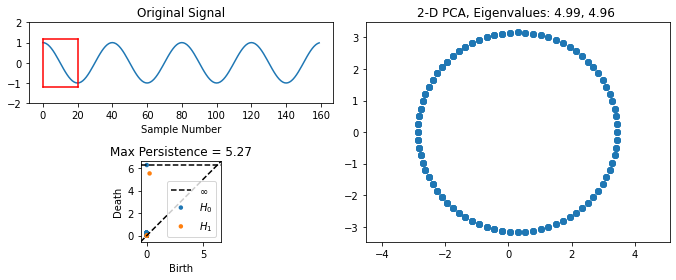

In [ ]:
dimsliderval = 20
tausliderval = 1
noiseval = 0
noise = np.random.randn(10000)

def on_value_change(change):

    global dimsliderval
    global tausliderval
    global noiseval

    global dimslider
    global Tauslider
    global noiseampslider

    dimsliderval = dimslider.value
    tausliderval = Tauslider.value
    noiseval = noiseampslider.value

    execute_computation1()

def execute_computation1():
    global dimsliderval
    global tausliderval
    global noiseval

    global dimslider
    global Tauslider
    global noiseampslider

    clear_output(wait=True)

    dimslider = widgets.IntSlider(min=1,max=100,value=dimsliderval,description='Dimension:',continuous_update=False)
    dimslider.observe(on_value_change, names='value')

    Tauslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=tausliderval,description=r'\(\tau :\)' ,continuous_update=False)
    Tauslider.observe(on_value_change, names='value')

    noiseampslider = widgets.FloatSlider(min=0,max=2,step=0.1,value=noiseval,description='Noise Amplitude',continuous_update=False)
    noiseampslider.observe(on_value_change, names='value')

    fig = plt.figure(figsize=(9.5, 4))

    display(widgets.HBox(( dimslider,Tauslider, noiseampslider)))

    plt.clf()
    # Step 1: Setup the signal
    T = 40 # The period in number of samples
    NPeriods = 4 # How many periods to go through
    N = T*NPeriods # The total number of samples
    t = np.linspace(0, 2*np.pi*NPeriods, N+1)[0:N] # Sampling indices in time
    x = np.cos(t) # The final signal
    x += noiseampslider.value * noise[:len(x)]

    # Step 2: Do a sliding window embedding
    dim = dimslider.value
    Tau = Tauslider.value
    dT = 0.5
    X = getSlidingWindow(x, dim, Tau, dT)
    extent = Tau*dim

    # Step 3: Do Rips Filtration
    PDs = ripser(X, maxdim=1)['dgms']
    I = PDs[1]

    # Step 4: Perform PCA down to 2D for visualization
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_

    # Step 5: Plot original signal, 2-D projection, and the persistence diagram
    gs = gridspec.GridSpec(2, 2)
    ax = plt.subplot(gs[0,0])
    ax.plot(x)
    ax.set_ylim((2*min(x), 2*max(x)))
    ax.set_title("Original Signal")
    ax.set_xlabel("Sample Number")
    yr = np.max(x)-np.min(x)
    yr = [np.min(x)-0.1*yr, np.max(x)+0.1*yr]
    ax.plot([extent, extent], yr, 'r')
    ax.plot([0, 0], yr, 'r')     
    ax.plot([0, extent], [yr[0]]*2, 'r')
    ax.plot([0, extent], [yr[1]]*2, 'r')

    ax2 = plt.subplot(gs[1,0])
    plot_diagrams(PDs)
    plt.title("Max Persistence = %.3g"%np.max(I[:, 1] - I[:, 0]))

    ax3 = plt.subplot(gs[:,1])
    ax3.scatter(Y[:, 0], Y[:, 1])
    plt.axis('equal')
    plt.title("2-D PCA, Eigenvalues: %.3g, %.3g "%(eigs[0],eigs[1]))

    plt.tight_layout()
  
execute_computation1()

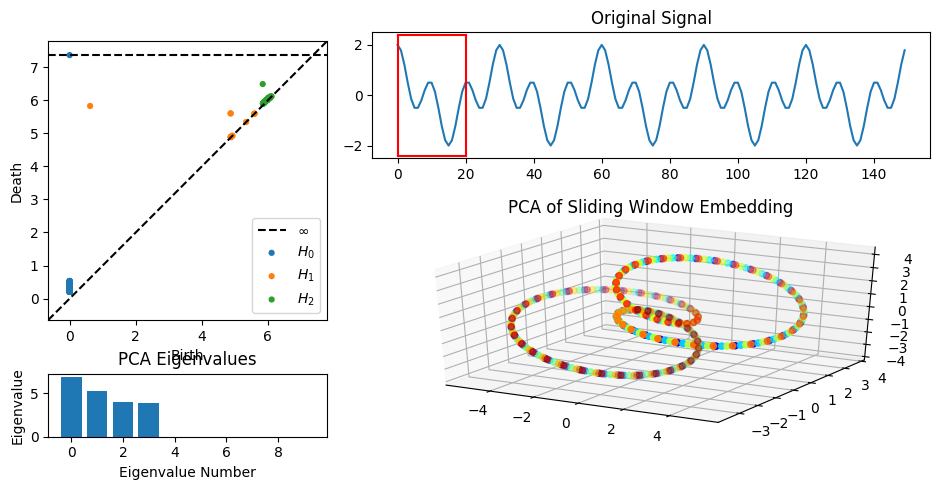

In [ ]:
secondfreqval = 3
dimsliderval = 20
tausliderval = 1
noiseval = 0
x = None
t = None


def on_value_change(change):
    global dimsliderval
    global tausliderval
    global noiseval
    global secondfreqval

    global dimslider
    global Tauslider
    global noiseampslider
    global secondfreq

    dimsliderval = dimslider.value
    tausliderval = Tauslider.value
    noiseval = noiseampslider.value
    secondfreqval = secondfreq.value

    execute_computation3()


noise = np.random.randn(10000)


def execute_computation3():
    global dimsliderval
    global tausliderval
    global noiseval
    global secondfreqval

    global dimslider
    global Tauslider
    global noiseampslider
    global secondfreq
    global x
    global t

    clear_output(wait=True)

    fig = plt.figure(figsize=(9.5, 5))

    secondfreq = widgets.Dropdown(options=[ 2, 3, np.pi],value=secondfreqval,description='Second Frequency:',disabled=False)
    secondfreq.observe(on_value_change,names='value')

    noiseampslider = widgets.FloatSlider(min=0,max=2,step=0.1,value=noiseval,description='Noise Amplitude',continuous_update=False)
    noiseampslider.observe(on_value_change, names='value')

    dimslider = widgets.IntSlider(min=1,max=40,value=dimsliderval,description='Dimension:',continuous_update=False)
    dimslider.observe(on_value_change, names='value')

    Tauslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=tausliderval,description=r'\(\tau :\)' ,continuous_update=False)
    Tauslider.observe(on_value_change, names='value')

    display(widgets.HBox(( dimslider,Tauslider)))
    display(widgets.HBox(( secondfreq,noiseampslider)))

    # Step 1: Setup the signal
    T1 = 10 # The period of the first sine in number of samples
    T2 = T1*secondfreq.value # The period of the second sine in number of samples
    NPeriods = 5 # How many periods to go through, relative to the second sinusoid
    N = T2*NPeriods # The total number of samples
    t = np.arange(N) # Time indices
    x = np.cos(2*np.pi*(1.0/T1)*t) # The first sinusoid
    x += np.cos(2*np.pi*(1.0/T2)*t) # The second sinusoid
    x += noiseampslider.value * noise[:len(x)]

    #Step 2: Do a sliding window embedding
    dim = dimslider.value
    Tau = Tauslider.value
    dT = 0.35
    X = getSlidingWindow(x, dim, Tau, dT)
    extent = Tau*dim

    #Step 3: Do Rips Filtration
    PDs = ripser(X, maxdim=2, n_perm=200)['dgms']

    #Step 4: Perform PCA down to 2D for visualization
    pca = PCA()
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_

    #Step 5: Plot original signal and the persistence diagram
    gs = gridspec.GridSpec(3, 2,width_ratios=[1, 2],height_ratios=[2,2,1])
    
    ax = plt.subplot(gs[0,1])
    ax.plot(x)
    ax.set_ylim((1.25*min(x), 1.25*max(x)))
    ax.set_title("Original Signal")
    #ax.set_xlabel("Sample Number")
    yr = np.max(x)-np.min(x)
    yr = [np.min(x)-0.1*yr, np.max(x)+0.1*yr]
    ax.plot([extent, extent], yr, 'r')
    ax.plot([0, 0], yr, 'r')     
    ax.plot([0, extent], [yr[0]]*2, 'r')
    ax.plot([0, extent], [yr[1]]*2, 'r')

    ax2 = plt.subplot(gs[0:2,0])
    plot_diagrams(PDs)

    ax3 = plt.subplot(gs[2,0])
    eigs = eigs[0:min(len(eigs), 10)]
    ax3.bar(np.arange(len(eigs)), eigs)
    ax3.set_xlabel("Eigenvalue Number")
    ax3.set_ylabel("Eigenvalue")
    ax3.set_title("PCA Eigenvalues")

    c = plt.get_cmap('jet')
    C = c(np.array(np.round(np.linspace(0, 255, Y.shape[0])), dtype=np.int32))
    C = C[:, 0:3]
    ax4 = fig.add_subplot(gs[1:,1], projection = '3d')
    ax4.set_title("PCA of Sliding Window Embedding")
    ax4.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=C)
    #ax4.set_aspect('equal', 'datalim')
    plt.tight_layout()

execute_computation3()

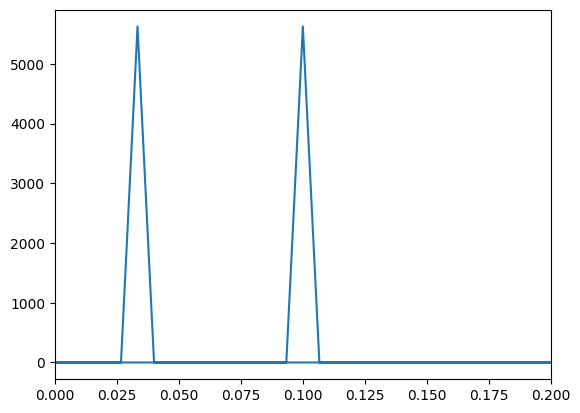

In [ ]:
# we can get the frequencies of each signal above by computing the Fourier transform.
# each peak corresponds to a sinusoid, and its position determines its frequency.
# interpret this plot!

plt.figure()
P1 = np.abs(np.fft.fft(x))**2
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq, P1)
plt.xlim((0,0.2))
plt.show()

## **Optional**: dissonance detection
We use persistence homology to detect dissonance in music.
We dowload a recording of a tritone, which consists of an interval (two notes played at the same time), in which the second frequency is square-root of two time the first frequency. In particular, the two frequencies are inconmensurable over the rational numbers, and thus one should be able to find parameters for the sliding window embedding to get a 2D torus.

In [ ]:
! wget https://github.com/LuisScoccola/emalca-applied-topology-minicourse/blob/main/data/tritone.wav?raw=true -O tritone.wav

--2021-11-12 17:19:41--  https://github.com/LuisScoccola/emalca-applied-topology-minicourse/blob/main/data/tritone.wav?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/LuisScoccola/emalca-applied-topology-minicourse/raw/main/data/tritone.wav [following]
--2021-11-12 17:19:41--  https://github.com/LuisScoccola/emalca-applied-topology-minicourse/raw/main/data/tritone.wav
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/LuisScoccola/emalca-applied-topology-minicourse/main/data/tritone.wav [following]
--2021-11-12 17:19:42--  https://raw.githubusercontent.com/LuisScoccola/emalca-applied-topology-minicourse/main/data/tritone.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.

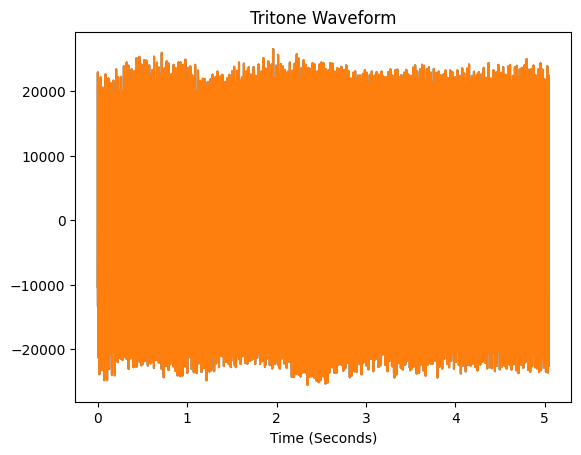

In [ ]:
#Read in the audio file.  Fs is the sample rate, and
#X is the audio signal
Fs, X = scipy.io.wavfile.read("tritone.wav")
plt.figure()
plt.plot(np.arange(len(X))/float(Fs), X)
plt.xlabel("Time (Seconds)")
plt.title("Tritone Waveform")
plt.show()

from IPython.display import Audio
# load a remote WAV file
Audio('tritone.wav')

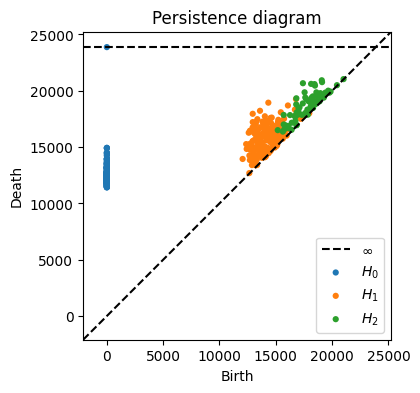

In [ ]:
# Find the torus!
# you may want to use the code above to compute the Fourier transform to first get an estimate of the frequencies of the two notes being played. 

tau = 10
dim = 8
SigLen = 20000 #The number of samples to take after the start time


#Step 1: Extract an audio snippet starting at the chosen time
iStart = 30
x = X[iStart:iStart + SigLen,0]

#Step 2: Get the sliding window embedding
Y = getSlidingWindow(x, dim, tau, 1)

#Step 3: Do the 1D rips filtration
PDs = ripser(Y, maxdim=2, n_perm=200)['dgms']
PD = PDs[1]

#Step 4: Figure out the second largest persistence
sP = 0
sPIdx = 0
if PD.shape[0] > 1:
    Pers = PD[:, 1] - PD[:, 0]
    sPIdx = np.argsort(-Pers)[1]
    sP = Pers[sPIdx]
    
#Step 5: Plot the results
plt.figure(figsize=(8, 4))
plot_diagrams(PDs)
_ = plt.title("Persistence diagram")

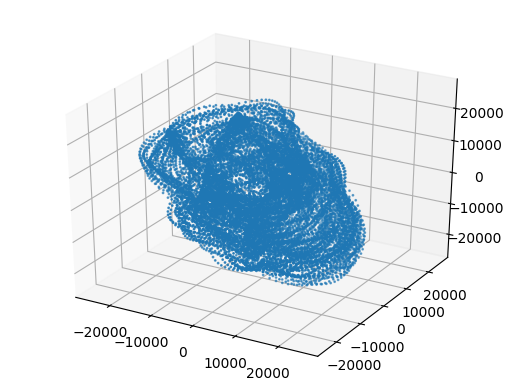

In [ ]:
# you can use the code below to get a low dimensional representation of the sliding window pointcloud

from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
emb = pca.fit_transform(Y)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
_ = ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], s=1)